In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [37]:
# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]


In [39]:
def detect_objects(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if image was successfully loaded
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    
    # Prepare image for YOLO (blob conversion)
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getLayers()]
    
    # Run forward pass to get predictions
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    # Process detections
    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                # Append to list
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image


In [41]:
def postprocess_boxes(class_ids, confidences, boxes, image):
    # Apply non-maxima suppression (NMS) to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            if label in ["knife", "gun", "missile", "weapon"]:  # Weapon classes
                risky = True  # If weapon detected, mark as risky
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return risky, image


In [43]:
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    return label


In [49]:
!pip install --upgrade opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:01m


In [57]:
import cv2

# Test if OpenCV can load the YOLO model
try:
    net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")
    print("YOLO model loaded successfully")
except Exception as e:
    print(f"Error loading YOLO model: {e}")


YOLO model loaded successfully


In [59]:
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getLayers()]
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image


In [61]:
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            if label in ["knife", "gun", "missile", "weapon"]:  # Weapon classes
                risky = True  # If weapon detected, mark as risky
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return risky, image


In [63]:
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    return label


In [71]:
pip install opencv-python-headless numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


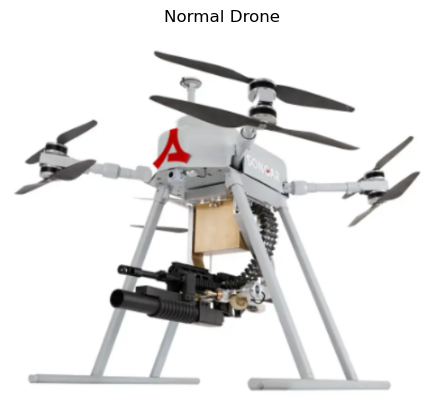

The drone is: Normal Drone


In [77]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Function to detect objects in the image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names from the model
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform forward pass
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image

# Function to process detections and classify as risky or normal
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            if label in ["knife", "gun", "missile", "weapon"]:  # Weapon classes
                risky = True  # If weapon detected, mark as risky
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return risky, image

# Final classification function for risky or normal drone
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    return label

# Test with an image (Make sure the image path is correct)
image_path = "drone.png"  # Replace with your image path
result = classify_drone(image_path)
print(f"The drone is: {result}")


Detected: person with confidence: 0.47679516673088074


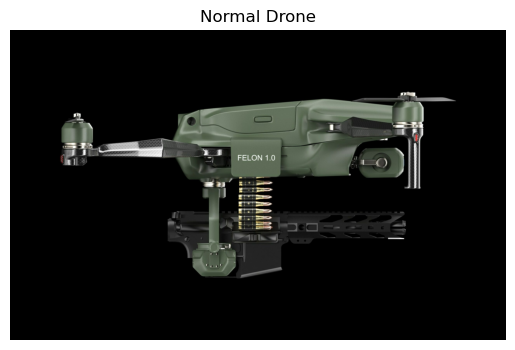

The drone is: Normal Drone


In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Define a list of dangerous object classes (like weapon-related items)
risky_classes = ["knife", "gun", "missile", "rocket launcher"]

# Function to detect objects in the image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names from the model
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform forward pass
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.4:  # Lowered threshold to detect more objects
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image

# Function to process detections and classify as risky or normal
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.4, nms_threshold=0.3)  # Lowered NMS threshold
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]  # Store confidence value for debugging
            print(f"Detected: {label} with confidence: {confidence}")  # Debug print
            
            # Check if the detected object is in the list of risky classes
            if label in risky_classes:
                risky = True  # If weapon detected, mark as risky
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return risky, image

# Final classification function for risky or normal drone
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    return label

# Test with an image (Make sure the image path is correct)
image_path = "12.jpg"  # Replace with your image path
result = classify_drone(image_path)
print(f"The drone is: {result}")


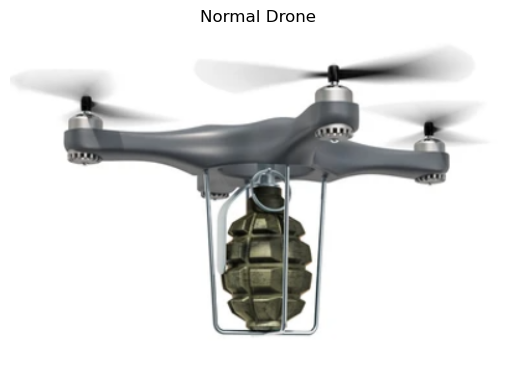

The drone is: Normal Drone


In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Define a list of dangerous object classes (like weapon-related items)
risky_classes = ["knife", "gun", "missile", "rocket launcher"]

# Function to detect objects in the image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names from the model
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform forward pass
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.6:  # Adjusted confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image

# Function to process detections and classify as risky or normal
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.4, nms_threshold=0.4)  # Adjusted thresholds
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]  # Store confidence value for debugging
            print(f"Detected: {label} with confidence: {confidence}")  # Debug print
            
            # If the detected object is a risky class, flag it as risky
            if label in risky_classes:
                risky = True  # Mark as risky if weapon is detected
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            
            # If the object is not risky and is a "drone" class, label it as normal drone
            elif label == "drone":  # Add "drone" label from coco names if available
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(image, "Normal Drone", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return risky, image

# Final classification function for risky or normal drone
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    # Optionally, display image using OpenCV
    # cv2.imshow("Detected Image", result_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return label

# Test with an image (Make sure the image path is correct)
image_path = "bomb.png"  # Replace with your image path
result = classify_drone(image_path)
print(f"The drone is: {result}")


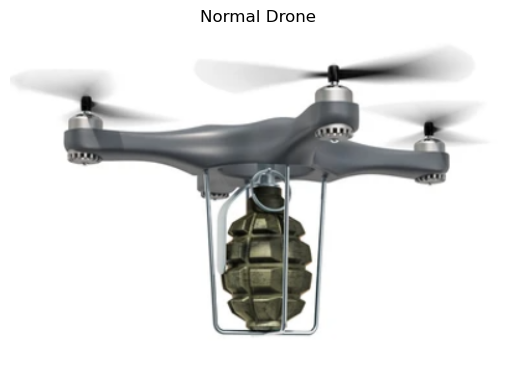

The drone is: Normal Drone


In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Define a list of dangerous object classes (like weapon-related items)
risky_classes = ["knife", "gun", "missile", "rocket launcher", "grenade"]  # Ensure "grenade" is correctly spelled

# Function to detect objects in the image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names from the model
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform forward pass
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Lowered confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image

# Function to process detections and classify as risky or normal
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)  # Adjusted thresholds
    
    risky = False  # Flag to check if the drone is risky
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]  # Store confidence value for debugging
            print(f"Detected: {label} with confidence: {confidence}")  # Debug print
            
            # Check if the detected object is in the risky class list
            if label in risky_classes:
                risky = True  # Mark as risky if weapon is detected
                # Draw the bounding box in red for risky objects
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                # Draw label box with "Risky" label
                cv2.rectangle(image, (x, y - 30), (x + w, y), (0, 0, 255), -1)
                cv2.putText(image, "Risky Drone", (x + 5, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            # If it's a normal drone (no risky object detected), label it as normal
            elif label == "drone":  # If drone is detected
                # Draw the bounding box in green for normal drones
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # Draw label box with "Normal" label
                cv2.rectangle(image, (x, y - 30), (x + w, y), (0, 255, 0), -1)
                cv2.putText(image, "Normal Drone", (x + 5, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return risky, image

# Final classification function for risky or normal drone
def classify_drone(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    risky, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if risky:
        label = "Risky Drone"
    else:
        label = "Normal Drone"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    # Optionally, display image using OpenCV
    # cv2.imshow("Detected Image", result_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return label

# Test with an image (Make sure the image path is correct)
image_path = "bomb.png"  # Replace with your image path
result = classify_drone(image_path)
print(f"The drone is: {result}")

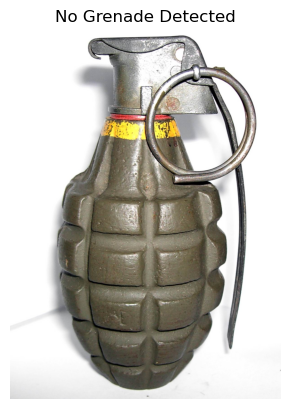

Result: No Grenade Detected


In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load YOLO model (weights and config)
net = cv2.dnn.readNet("yolov3_2000.weights", "yolov3.cfg")

# Load class labels (COCO dataset contains 80 labels)
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Define a list of dangerous object classes (only "grenade" now)
risky_classes = ["grenade"]

# Function to detect objects in the image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path and try again.")
    
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get output layer names from the model
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform forward pass
    detections = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in detections:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Lowered confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return class_ids, confidences, boxes, image

# Function to process detections and classify as risky (grenade) or not
def postprocess_boxes(class_ids, confidences, boxes, image):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)  # Adjusted thresholds
    
    grenade_detected = False  # Flag to check if a grenade is detected
    
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]  # Store confidence value for debugging
            print(f"Detected: {label} with confidence: {confidence}")  # Debug print
            
            # Check if the detected object is a grenade
            if label == "grenade":
                grenade_detected = True  # Mark as risky if grenade is detected
                # Draw the bounding box in red for grenade
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                # Draw label box with "Grenade" label
                cv2.rectangle(image, (x, y - 30), (x + w, y), (0, 0, 255), -1)
                cv2.putText(image, "Grenade", (x + 5, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return grenade_detected, image

# Final classification function for detecting grenade
def classify_grenade(image_path):
    class_ids, confidences, boxes, image = detect_objects(image_path)
    grenade_detected, result_image = postprocess_boxes(class_ids, confidences, boxes, image)

    # Display final result
    if grenade_detected:
        label = "Grenade Detected"
    else:
        label = "No Grenade Detected"

    # Show image using matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

    # Optionally, display image using OpenCV
    # cv2.imshow("Detected Image", result_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return label

# Test with an image (Make sure the image path is correct)
image_path = "grd.jpeg"  # Replace with your image path
result = classify_grenade(image_path)
print(f"Result: {result}")


In [109]:
cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/home/samiun/AI Driven Drone Detection Assesment


In [111]:
cd yolov5-master


/home/samiun/AI Driven Drone Detection Assesment/yolov5-master


In [113]:
pip install -U -r requirements.txt

  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached psutil-6.1.1-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.5 MB/s eta 0:00:000:00:01m eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:02
Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)
Using cached psutil-6.1.1-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (287 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 1.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 1.5 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━